In [2]:
import nibabel as nib
import numpy as np
import pydicom
from tkinter import filedialog
import tkinter as tk
import glob
from tqdm import tqdm
import torch
import h5py
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

In [3]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def tkinter_gui(flavour_text):
    """
    This function creates a Tkinter window for browsing directories and returns the selected directory path.

    Parameters
    ----------
    flavour_text : str
        A string to display in the Tkinter window.

    Returns
    -------
    selected_directory : str
        The selected directory path.

    Examples
    --------
    >>> selected_directory = tkinter_gui("Select a directory")
    """
    
    def browse_directory():
        directory_path = filedialog.askdirectory()
        if directory_path:
            nonlocal selected_directory
            selected_directory = directory_path
            root.destroy()  # Close the Tkinter window

    # Create the main window
    root = tk.Tk()
    root.title("Directory Browser")

    # Create a label and button to display selected directory and browse
    directory_label = tk.Label(root, text=flavour_text, padx=10, pady=10)
    directory_label.pack()
    browse_button = tk.Button(root, text="Browse", command=browse_directory)
    browse_button.pack()

    # Run the application
    selected_directory = None  # Initialize selected_directory variable
    root.mainloop()
    if selected_directory:
        return selected_directory   
    else:
        raise ValueError("No directory selected")
    

def normalization_container(data, dims_inp):
    """
    This function z-score normalizes the data in the input array.

    Parameters
    ----------
    data : numpy.ndarray
        The input data array to be normalized.
    dims_inp : tuple/list
        The dimensions of the input data array.

    Returns
    -------
    image_container : numpy.ndarray
        The normalized data array.

    Examples
    --------
    >>> data_normalized = normalization_container(data, dims_inp)
    """

    print("Normalizing data...")

    # Create an empty array to store the normalized data
    image_container = np.empty((0, dims_inp[1], dims_inp[2]))

    # Iterate over the data and normalize each slice
    for image in tqdm(data):
        for slice in image:
            ninetynine_max = np.percentile(slice, 99)
            one_min = np.percentile(slice, 1)
            slice = np.clip(slice, one_min, ninetynine_max)

            curr_mean = np.mean(slice)
            curr_std = np.std(slice)
            slice = (slice - curr_mean) / curr_std
            slice = np.array([slice])
            image_container = np.concatenate((image_container, slice), axis=0, dtype=np.float32)
    
    return image_container


def normalization_container_torch_cuda(data, counter, dirname, dims_inp):
    """
    This function z-score normalizes the data in the input array and saves the normalized data as PyTorch tensors.

    Parameters
    ----------
    data : numpy.ndarray
        The input data array to be normalized.
    counter : int
        The counter to be used in the file name.
    dirname : str
        The directory path to save the normalized data.
    dims_inp : tuple/list
        The dimensions of the input data array.

    Returns
    -------
    None

    Examples
    --------
    >>> normalization_container_torch_cuda(data, counter, dirname, dims_inp)
    """

    # Create a directory to save the normalized data
    if os.path.exists(dirname + "\\normalized_pt_tensors") == False:
        os.mkdir(dirname + "\\normalized_pt_tensors")
    else:
        if counter == 0:
            print("Save directory already exists, skipping creation...")

    # Create an empty tensor to store the normalized data
    image_container = (torch.from_numpy(np.empty((0, dims_inp[1], dims_inp[2])))).to(device)
    empty_arr = np.empty((0, dims_inp[1], dims_inp[2]))

    # Iterate over the data and normalize each slice
    for image in data:
        for slice_ in image:
            if np.max(slice_) == 0:
                continue
            else:
                ninetynine_max = np.percentile(slice_, 99)
                one_min = np.percentile(slice_, 1)
                slice_ = np.clip(slice_, one_min, ninetynine_max)

                curr_mean = np.mean(slice_)
                curr_std = np.std(slice_)
                slice_ = (slice_ - curr_mean) / curr_std
                slice_ = np.clip(slice_, -1, 1)

            slice_ = np.array([slice_], dtype=np.float32)

            # Convert the numpy array to a PyTorch tensor and move it to the GPU
            slice_ = torch.from_numpy(slice_).to(device)
            image_container = torch.cat((image_container, slice_), 0)
    
    # Save the normalized data     
    torch.save(image_container, dirname + "\\normalized_pt_tensors\\" + 'data_normalized_' + str(counter) + '.pt')

    return


def normalization_container_single_torch_cuda(data, counter, dirname, dims_inp):
    """
    This function z-score normalizes the data in the input array and saves the normalized data as PyTorch tensors.
    Functionality is identical to normalization_container_torch_cuda, but is used for single-slice data.

    Parameters
    ----------
    data : numpy.ndarray
        The input data array to be normalized.
    counter : int
        The counter to be used in the file name.
    dirname : str
        The directory path to save the normalized data.
    dims_inp : tuple/list
        The dimensions of the input data array.

    Returns
    -------
    None

    Examples
    --------
    >>> normalization_container_single_torch_cuda(data, counter, dirname, dims_inp)
    """

    # Create a directory to save the normalized data
    if os.path.exists(dirname + "\\normalized_pt_tensors") == False:
        os.mkdir(dirname + "\\normalized_pt_tensors")
    else:
        if counter == 0:
            print("Save directory already exists, skipping creation...")

    # Create an empty tensor to store the normalized data
    image_container = (torch.from_numpy(np.empty((0, dims_inp[0], dims_inp[1])))).to(device)

    # Normalize the data
    for slice_ in data:
        ninetynine_max = np.percentile(slice_, 99)
        one_min = np.percentile(slice_, 1)
        slice_ = np.clip(slice_, one_min, ninetynine_max)

        curr_mean = np.mean(slice_)
        curr_std = np.std(slice_)
        slice_ = (slice_ - curr_mean) / curr_std
        slice_ = np.clip(slice_, -1, 1)
        slice_ = np.array([slice_], dtype=np.float32)

         # Convert the numpy array to a PyTorch tensor and move it to the GPU
        slice_ = torch.from_numpy(slice_).to(device)
        image_container = torch.cat((image_container, slice_), 0)
    
    # Save the normalized data    
    torch.save(image_container, dirname + "\\normalized_pt_tensors\\" + 'data_normalized_' + str(counter) + '.pt')

    return

In [6]:
# Select the directory containing the data to be normalized
input_data_dir = tkinter_gui("Select the directory containing the data to be normalized")
input_files_dcm = glob.glob(input_data_dir + "/*.dcm", recursive=True)
input_files_nii = glob.glob(input_data_dir + "/*.nii", recursive=True)
input_files_nii_gz = glob.glob(input_data_dir + "/*.nii.gz", recursive=True)
input_files_h5 = glob.glob(input_data_dir + "/*.h5", recursive=True)

# Check the filetype of the input data
if len(input_files_dcm) > 0:
    mode = "dcm"
    print(len(input_files_dcm) , "DICOM files detected")
elif len(input_files_nii) > 0 or len(input_files_nii_gz) > 0:
    mode = "nii"
    if len(input_files_nii) > 0:
        print(len(input_files_nii) , "Nifti files detected")
    else:
        print(len(input_files_nii_gz) , "Nifti files detected")
elif len(input_files_h5) > 0:
    mode = "h5"
    print(len(input_files_h5) , "HDF5 files detected")
else:
    raise ValueError("No valid files detected in the directory")

# Set up initial variables
desired_batchsize = 20

400 HDF5 files detected


In [7]:
# Load the data and normalize it depending on the filetype

if mode == "nii":
    #load nifti files
    try:
        input_files = input_files_nii
        if len(input_files) == 0:
            raise Exception("No Nifti files detected")
    except:
        input_files = input_files_nii_gz

    print("Number of T1w Nifti files: ", len(input_files), "\n")

    data_batched = []
    dataloc_container = []
    temp_cont = []

    counter = 0
    for file in input_files:
        if counter == desired_batchsize:
            data_batched.append(temp_cont)
            temp_cont = []
            counter = 0
        temp_cont.append(file)
        counter += 1
    data_batched.append(temp_cont)

    counter = 0
    dataloc_container = []

    time.sleep(1)
    print(len(data_batched) -1, "batches of 20 images created (+1 final batch of", int(len(data_batched[-1])), "images)\n")

    #load nifti files and normalize
    time.sleep(1)
    print("Normalizing and saving data...")
    for batch in tqdm(data_batched):
        all_imgs = []
        temp_dataloc_container = []

        for file in (batch):
            img = nib.load(file)
            data = np.fliplr(np.transpose(img.get_fdata(), (2, 1, 0))) 
            dims = data.shape
            for i in range(dims[0]):
                temp_dataloc_container.append(file)
            #print("Data shape: ", dims)
            all_imgs.append(data)

        target = 150 ### set target slice count for all images - for IXI dataset, 150 slices is a good number
        padded_imgs = []

        #add empty slices to each image to make them all the same size - not necessary but seems to assist training
        for element in (all_imgs):
            element = np.array(element, dtype=np.float32)
            while element.shape[0] < target:
                element = np.concatenate((element, np.zeros((1, element.shape[1], element.shape[2]))), axis=0)
                temp_dataloc_container.append("empty")
            while element.shape[0] > target:
                element = np.delete(element, -1, axis=0)
                temp_dataloc_container = temp_dataloc_container[:-1]
            assert element.shape[0] == target
            assert element.shape[1] == dims[1], "Element shape: " + str(element.shape[1]) + " Dims: " + str(dims[1]) + "do not match"
            assert element.shape[2] == dims[2], "Element shape: " + str(element.shape[2]) + " Dims: " + str(dims[2]) + "do not match"
            if element.shape == dims:
                padded_imgs.append(element)

        #print("Number of images: ", len(padded_imgs))
        #print("Image dimensions: ", padded_imgs[0].shape)

        padded_imgs = np.array(padded_imgs, dtype=np.float32)

        #modify the data to be in the correct format for the model
        dataloc_container.append(temp_dataloc_container)
        del temp_dataloc_container, all_imgs

        #normalize the data and send to GPU tensor
        normalization_container_torch_cuda(padded_imgs, counter, input_data_dir, dims)

        del padded_imgs
        torch.cuda.empty_cache()
        counter += 1

    #flatten dataloc_container
    dataloc_container = [item for sublist in dataloc_container for item in sublist]


if mode == "dcm":
    input_files = input_files_dcm
    
    temp_inputfiles = []
    for file in input_files:
        dcm = pydicom.read_file(file)
        if "t1" in (dcm.SeriesDescription).lower():
            temp_inputfiles.append(file)
    input_files = temp_inputfiles

    print("Number of T1w DICOM files: ", len(input_files), "\n")
    data_batched = []
    dataloc_container = []
    temp_cont = []

    #load data
    counter = 0
    for file in input_files:
        dataloc_container.append(file)
        if counter == desired_batchsize:
            data_batched.append(temp_cont)
            temp_cont = []
            counter = 0
        temp_cont.append(file)
        counter += 1
    data_batched.append(temp_cont)

    print(len(data_batched) -1, "batches of 20 images created (+1 final batch of", len(data_batched[-1]), "images)\n")
    
    counter = 0
    #load dicom files and normalize
    print("Normalizing and saving data...")
    for batch in tqdm(data_batched):
        all_imgs = []

        for file in (batch):
            img = pydicom.read_file(file)
            data = img.pixel_array
            dims = data.shape
            all_imgs.append(data)
        
        #normalize the data and send to GPU tensor
        all_imgs = np.array(all_imgs, copy=False, dtype=np.float32)
        #print("Data shape: ", all_imgs.shape)
        normalization_container_single_torch_cuda(all_imgs, counter, input_data_dir, dims)

        del all_imgs
        torch.cuda.empty_cache()
        counter += 1


if mode == "h5":
    #get all h5 files in directory and subdirectories
    input_files = input_files_h5
    t1_files = []
 
    for file in input_files:
        try:
            f = h5py.File(file, 'r')
            seq = f.attrs["acquisition"]
            if 'T1' in seq.upper():
                t1_files.append(file)
        except:
            if 'T1' in file.upper():
                t1_files.append(file)
    input_files = t1_files

    print("Number of T1w HDF5 files: ", len(input_files), "\n")
    #batch data
    data_batched = []
    dataloc_container = []
    temp_cont = []

    counter = 0
    for file in input_files:
        if counter == desired_batchsize:
            data_batched.append(temp_cont)
            temp_cont = []
            counter = 0
        temp_cont.append(file)
        counter += 1
    data_batched.append(temp_cont)

    print(len(data_batched) -1, "batches of 20 images created (+1 final batch of", len(data_batched[-1]), "images)\n")

    counter = 0
    #load h5 files and normalize
    print("Normalizing and saving data...")
    for batch in tqdm(data_batched):
        all_imgs = []

        for file in (batch):
            filename = str(file)
            temp_img_cont = []
            try:
                f = h5py.File(file, 'r')
                pixel_data = f["reconstruction_rss"]
                for i, slice in enumerate(pixel_data):
                    temp_img_cont.append(slice)
                    dataloc_container.append(filename)
                data = np.array(temp_img_cont, copy=False, dtype=np.float32)
                dims = data.shape
                all_imgs.append(data)
            except:
                print("Error in file: ", file)
                break
            
        #send data to GPU tensor
        all_imgs = np.array(all_imgs, copy=False, dtype=np.float32)
        #print("Data shape: ", all_imgs.shape)

        normalization_container_torch_cuda(all_imgs, counter, input_data_dir, dims)

        del all_imgs
        torch.cuda.empty_cache()
        counter += 1

print("\n")
print(len(dataloc_container), "images normalized and saved")


Number of T1w HDF5 files:  150 

7 batches of 20 images created (+1 final batch of 10 images)

Normalizing and saving data...


  0%|          | 0/8 [00:00<?, ?it/s]

Save directory already exists, skipping creation...


100%|██████████| 8/8 [00:59<00:00,  7.48s/it]



2700 images normalized and saved


In [10]:
#save the filenames to a csv file
df = pd.DataFrame(dataloc_container)
df.to_csv(input_data_dir + "\\normalized_pt_tensors\\dataloc_container.csv", index=False, header=False)

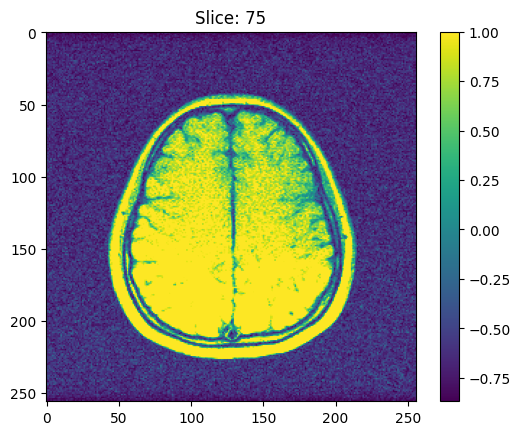

In [9]:
#visualize the data for review
pt_files = glob.glob(input_data_dir + '\\normalized_pt_tensors\\*pt')

for files in pt_files:
    data = torch.load(files)
    data_numpy = data.cpu().numpy()

    for i in range (len(data_numpy)):
        if i == 75:
            plt.imshow(data_numpy[i])
            plt.title("Slice: " + str(i))
            plt.colorbar()
            plt.show()

    break